### Problem Statement and Dataset Description

In this assignment,I am working with a dataset of network traffic flows collected using CICFlowMeter-
V3. The dataset contains both benign traffic and traffic from DDoS attacks.

My task is to develop
a solution that distinguishes between these two types of traffic. This document provides a high-level
overview of the approach, methodology, and deliverables expected in my submission.

In [166]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import matplotlib.cm as cm
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve


from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

import pickle

import warnings
warnings.filterwarnings('ignore')

**Loading the dataset**

In [167]:
import zipfile

zip_path = 'DDos.pcap_ISCX.csv.zip'

with zipfile.ZipFile(zip_path, 'r') as z:
    print("Files in the zip:", z.namelist())
    csv_filename = [f for f in z.namelist() if f.endswith('.csv')][0]
    with z.open(csv_filename) as f:
        df = pd.read_csv(f)


Files in the zip: ['Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv']


## **Data Exploration & Analysis**

In [168]:
data = df

#Shape of the data
print("Dataset Shape:", data.shape)

Dataset Shape: (225745, 85)


In [169]:
#Information about the DataFrame
print("\nDataFrame Info:")
data.info()


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225745 entries, 0 to 225744
Data columns (total 85 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Flow ID                       225745 non-null  object 
 1    Source IP                    225745 non-null  object 
 2    Source Port                  225745 non-null  int64  
 3    Destination IP               225745 non-null  object 
 4    Destination Port             225745 non-null  int64  
 5    Protocol                     225745 non-null  int64  
 6    Timestamp                    225745 non-null  object 
 7    Flow Duration                225745 non-null  int64  
 8    Total Fwd Packets            225745 non-null  int64  
 9    Total Backward Packets       225745 non-null  int64  
 10  Total Length of Fwd Packets   225745 non-null  int64  
 11   Total Length of Bwd Packets  225745 non-null  int64  
 12   Fwd Packet Length Max     

In [170]:
# Check for missing (null) values in each column
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
Flow ID              0
 Source IP           0
 Source Port         0
 Destination IP      0
 Destination Port    0
                    ..
Idle Mean            0
 Idle Std            0
 Idle Max            0
 Idle Min            0
 Label               0
Length: 85, dtype: int64


There are no null values present in our data so we dont need to drop any of the rows and columns as of now.

In [171]:
#Descriptive statistics
print("\nDescriptive Statistics:")
from IPython.display import display
display(data.describe().style.background_gradient(cmap='viridis'))


Descriptive Statistics:


,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225741.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000
mean,38257.568402,8879.619460,7.600288,16241648.528131,4.874916,4.572775,939.463346,5960.477455,538.535693,27.882221,164.826715,214.907242,2735.585147,16.718776,890.536849,1230.172938,inf,inf,1580587.237381,4248569.380689,13489773.823713,28118.547720,15396522.995526,2540609.509218,5195207.380946,12994339.103635,207369.826685,6564701.086553,947632.220446,1610306.243169,4567514.461543,225781.744110,0.033223,0.000000,0.000000,0.000000,111.522718,106.789023,12615.082673,1641.692750,8.072595,3226.045339,515.002137,1085.593207,2789905.545214,0.002671,0.033223,0.000120,0.351162,0.504463,0.140752,0.000000,0.000120,1.005821,574.568843,164.826715,890.536849,111.522718,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.874916,939.463346,4.572775,5960.477455,4247.436922,601.048635,3.311497,21.482753,184826.092693,12934.357551,208084.868631,177620.088852,10322143.418774,3611942.927448,12878128.943884,7755355.092946
std,23057.302075,19754.647400,3.881586,31524374.231941,15.422874,21.755356,3249.403484,39218.337446,1864.128991,163.324159,504.892965,797.411073,3705.123460,50.480568,1120.324921,1733.201267,nan,nan,2701595.785481,7622819.077286,26701716.686244,759810.041138,31608257.664857,5934694.001613,10786352.442587,27488695.815126,3795227.553760,21984549.331301,4586373.976131,5475777.673099,16178651.193530,4019289.758686,0.179220,0.000000,0.000000,0.000000,375.790727,511.765795,110670.135716,19895.934192,15.767713,3813.134850,559.064495,1269.558714,4115940.962769,0.051614,0.179220,0.010936,0.477334,0.499981,0.347766,0.000000,0.010

In [172]:
#To remove all the extra whitespaces from the feature names
data.columns = data.columns.str.strip()
print(data.Label.unique())

['BENIGN' 'DDoS']


#### Dataset Distribution and Data Split Analysis

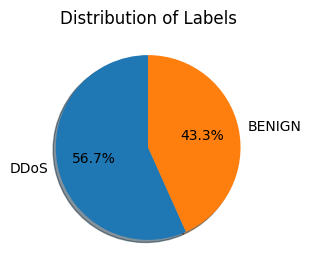

In [173]:
vc = data.Label.value_counts()

# Extract labels and sizes from the Value Count Series
labels = vc.index.tolist()
sizes = vc.values.tolist()

# Create the pie chart
plt.figure(figsize=(3, 3))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Distribution of Labels")
plt.show()



I have analyzed the dataset and observed the following label distribution:

- **DDoS:** 128,027 samples (~57%)
- **Benign:** 97,718 samples (~43%)

I consider this distribution to be very moderately imbalanced. For my initial modeling efforts, I will use the current data split as it is.

##### **My Approach:**
- I will start by training a baseline model using this data split.
- I will carefully monitor how the model handles both the DDoS and Benign classes.
- If I notice that the model consistently misclassifies the Benign samples, I will explore imbalance correction techniques such as adjusting class weights or applying resampling methods (like SMOTE) to better balance the dataset.

For now, I will proceed with the current data split and re-evaluate my strategy based on the model's performance.


# Exploratory Data Analysis (EDA) via Visualization

I plot the distribution of key numeric features('Flow Duration') to understand their spread and detect any potential outliers.

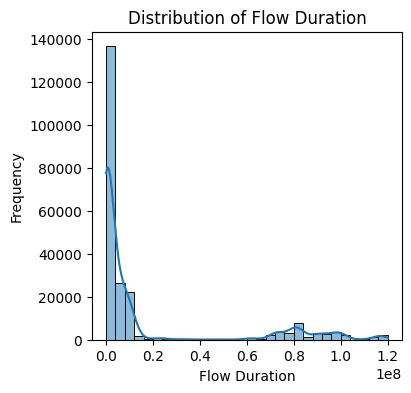

In [174]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of 'Flow Duration'
plt.figure(figsize=(4, 4))
sns.histplot(data['Flow Duration'], bins=30, kde=True)
plt.title('Distribution of Flow Duration')
plt.xlabel('Flow Duration')
plt.ylabel('Frequency')
plt.show()

The above histogram shows that the **Flow Duration** feature is highly skewed toward shorter durations. The majority of flows occur in a very short time frame, with only a small fraction extending to significantly higher durations. This long-tailed distribution suggests that most network flows complete quickly, while a few flows last much longer.


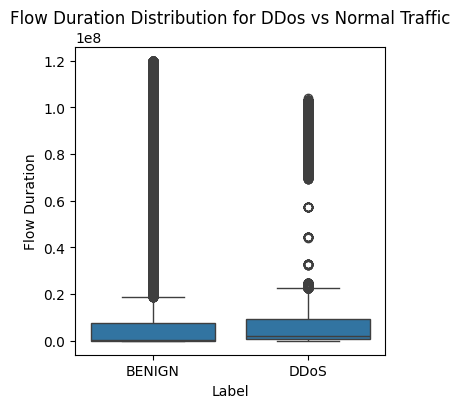

In [175]:
# Boxplot of Flow Duration by Attack Label
plt.figure(figsize=(4, 4))
sns.boxplot(x="Label", y="Flow Duration", data=data)
plt.title("Flow Duration Distribution for DDos vs Normal Traffic")
plt.show()

**Flow Duration Distribution (DDoS vs. Benign)**

Both classes have low median flow durations, but DDoS shows more extreme outliers. This suggests most flows end quickly, yet some DDoS flows persist much longer. Further features may be needed to accurately distinguish between the two classes.


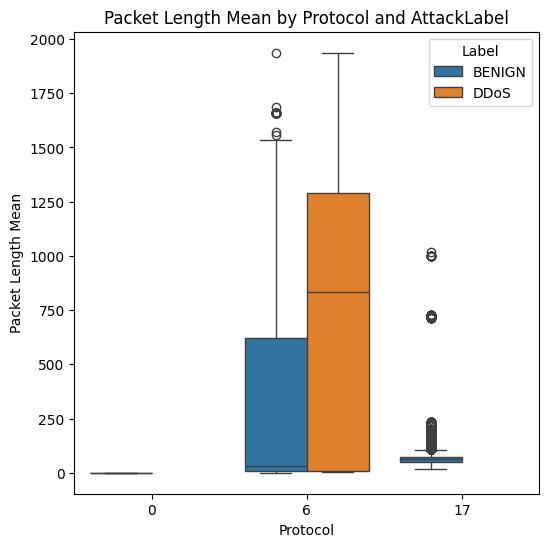

In [176]:
# Boxplot of Packet Length Mean by Protocol and Label
plt.figure(figsize=(6, 6))
sns.boxplot(x="Protocol", y="Packet Length Mean", hue="Label", data=df)
plt.title("Packet Length Mean by Protocol and AttackLabel")
plt.show()



This boxplot shows that for Protocol 6 (TCP), DDoS tends to have a higher mean packet length with more extreme outliers than BENIGN. Protocols 0 and 17 have generally lower packet length means, though some outliers still appear.


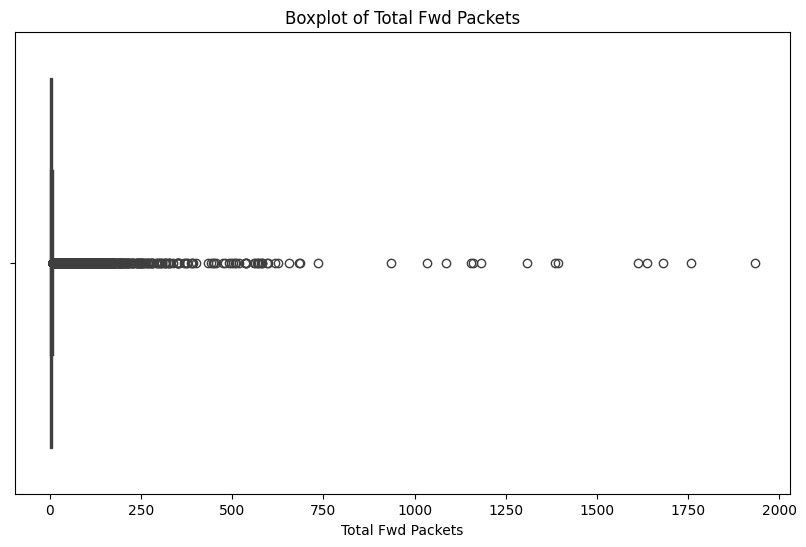

In [177]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['Total Fwd Packets'])
plt.title('Boxplot of Total Fwd Packets')
plt.xlabel('Total Fwd Packets')
plt.show()


**Different Packet Flags and Attack Patterns**


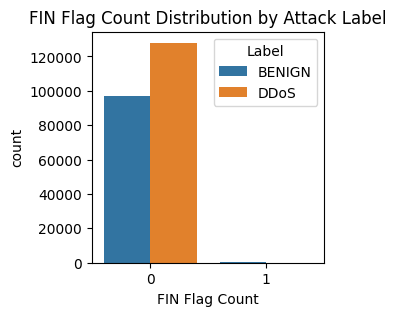

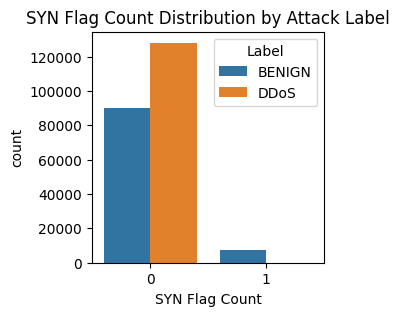

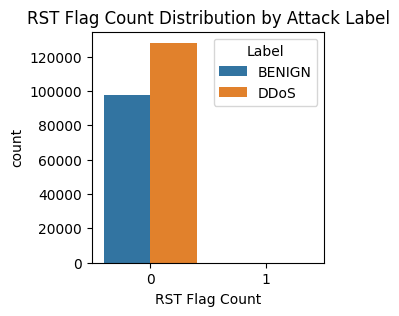

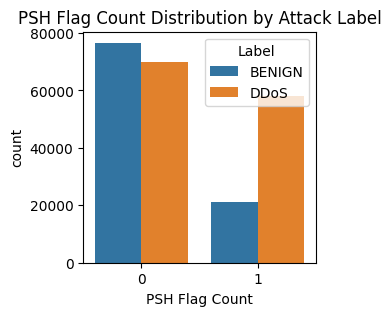

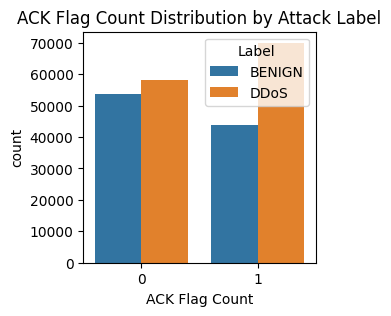

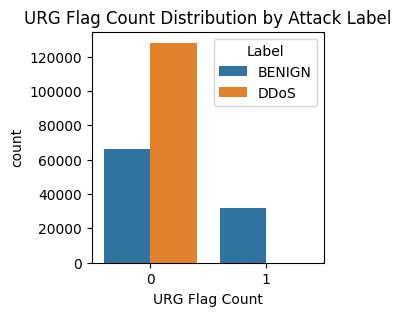

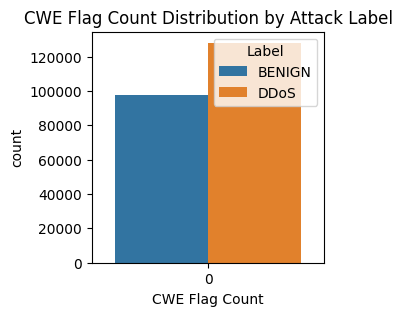

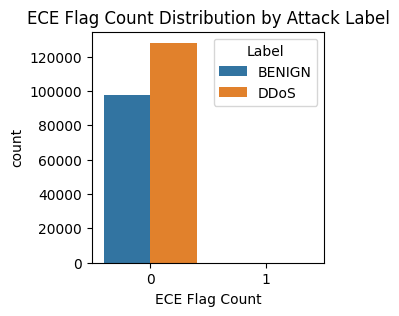

In [178]:
# Counting the number of occurrences of each flag in attack vs normal traffic

flag_cols = [col for col in df.columns if "Flag " in col]

for flag in flag_cols:
    plt.figure(figsize=(3, 3))
    sns.countplot(x=flag, hue="Label", data=df)
    plt.title(f"{flag} Distribution by Attack Label")
    plt.show()


#### Flag Distributions by Attack Label

These bar charts compare various flags (FIN, SYN, PSH, ACK, CWE, ECE) between **BENIGN** and **DDoS** traffic. Across most flags, the majority of flows have the flag set to 0, with some differences in the counts for 1. While these plots suggest certain variations (e.g., more DDoS flows in some flags), no single flag alone appears to be a definitive separator between DDoS and benign traffic. Combining multiple features may be necessary for effective classification.


**Correlation Analysis**

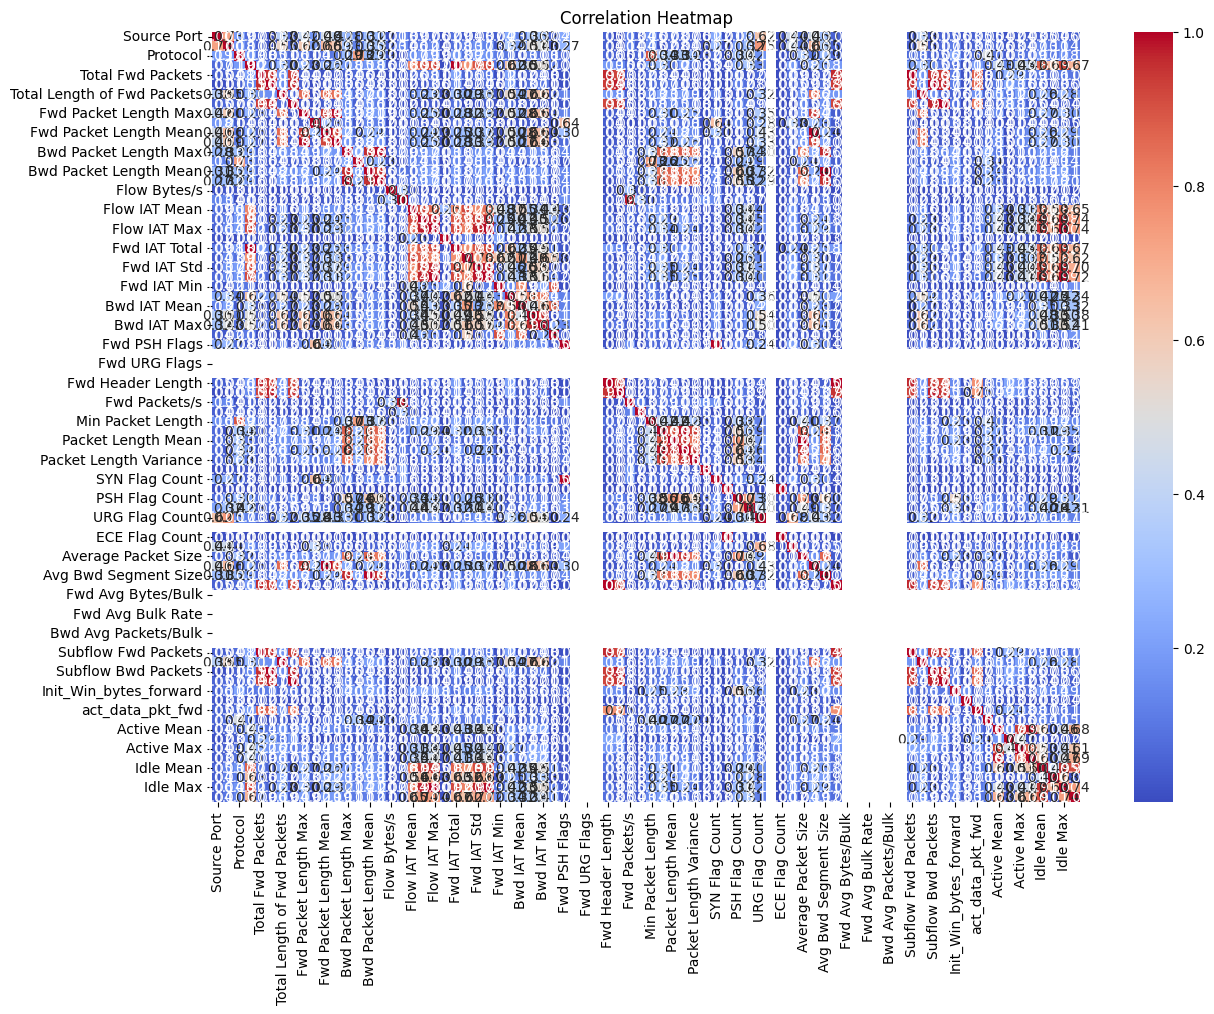

In [179]:
import numpy as np

numeric_data = data.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr().abs()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


#### Correlation Heatmap

This heatmap visualizes the pairwise correlations among the numerical features in the dataset. Diagonal elements are all 1.0 by definition, indicating each feature’s correlation with itself. The closer a value is to 1 or -1, the stronger the positive or negative relationship between the two features.

From this plot, we can see several features that exhibit strong positive or negative correlations with one another. In the **feature engineering** phase, I plan to drop one of any two features whose correlation exceeds **0.85** to reduce multicollinearity and improve model performance.


#### Correlation with the Target Variable

In [180]:
# Map the target variable to numeric values
data['Label_numeric'] = data['Label'].map({'BENIGN': 0, 'DDoS': 1})

# Include the numeric target in the correlation analysis
numeric_features = data.select_dtypes(include=[np.number]).columns.tolist()

# Compute the correlation matrix including the numeric target
corr_matrix = data[numeric_features].corr()

# Show the correlation of each feature with the target variable
target_corr = corr_matrix['Label_numeric'].sort_values(ascending=False)
print("Correlation with target variable:\n", target_corr)

Correlation with target variable:
 Label_numeric             1.000000
Bwd Packet Length Mean    0.603299
Avg Bwd Segment Size      0.603299
Bwd Packet Length Max     0.577323
Bwd Packet Length Std     0.576155
                            ...   
Fwd Avg Packets/Bulk           NaN
Fwd Avg Bulk Rate              NaN
Bwd Avg Bytes/Bulk             NaN
Bwd Avg Packets/Bulk           NaN
Bwd Avg Bulk Rate              NaN
Name: Label_numeric, Length: 81, dtype: float64


#### Correlation with Target Variable

The above table shows how each feature correlates with the target ("Label_numeric").For instance, "Bwd Packet Length Mean" and "Avg Bwd Segment Size" appear to have the highest positive correlations with the target, suggesting they may be important features for classification.

Features with **NaN** likely have no valid correlation. I will prioritize features with strong positive or negative correlations for further analysis or modeling and consider dropping or transforming features that show minimal/ undefined correlation.


### Feature Relationships and Patterns

To better understand how the features interact and differ between DDoS and BENIGN traffic, I perform the following analyses:

- **Scatter Plots:**  
  I use scatter plots to explore relationships between specific pairs of features.

- **Pair Plots:**  
  I create pair plots on a subset of important numerical features.

- **Grouped Statistics:**  
  I group the data by `Label` to compare summary statistics (like the mean) of various features between DDoS and BENIGN traffic.

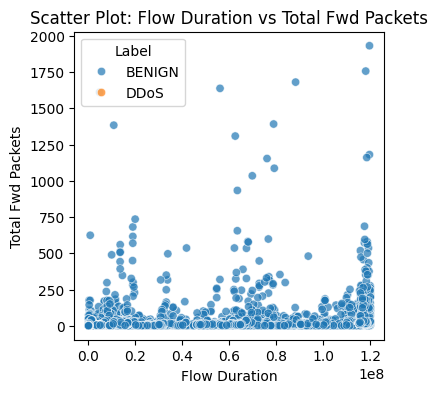

Columns used for pairplot: ['Flow Duration', 'Total Fwd Packets', 'Total Length of Fwd Packets', 'Bwd Packet Length Max', 'Total Backward Packets', 'Down/Up Ratio', 'Active Mean', 'Active Std', 'Idle Std', 'Label']


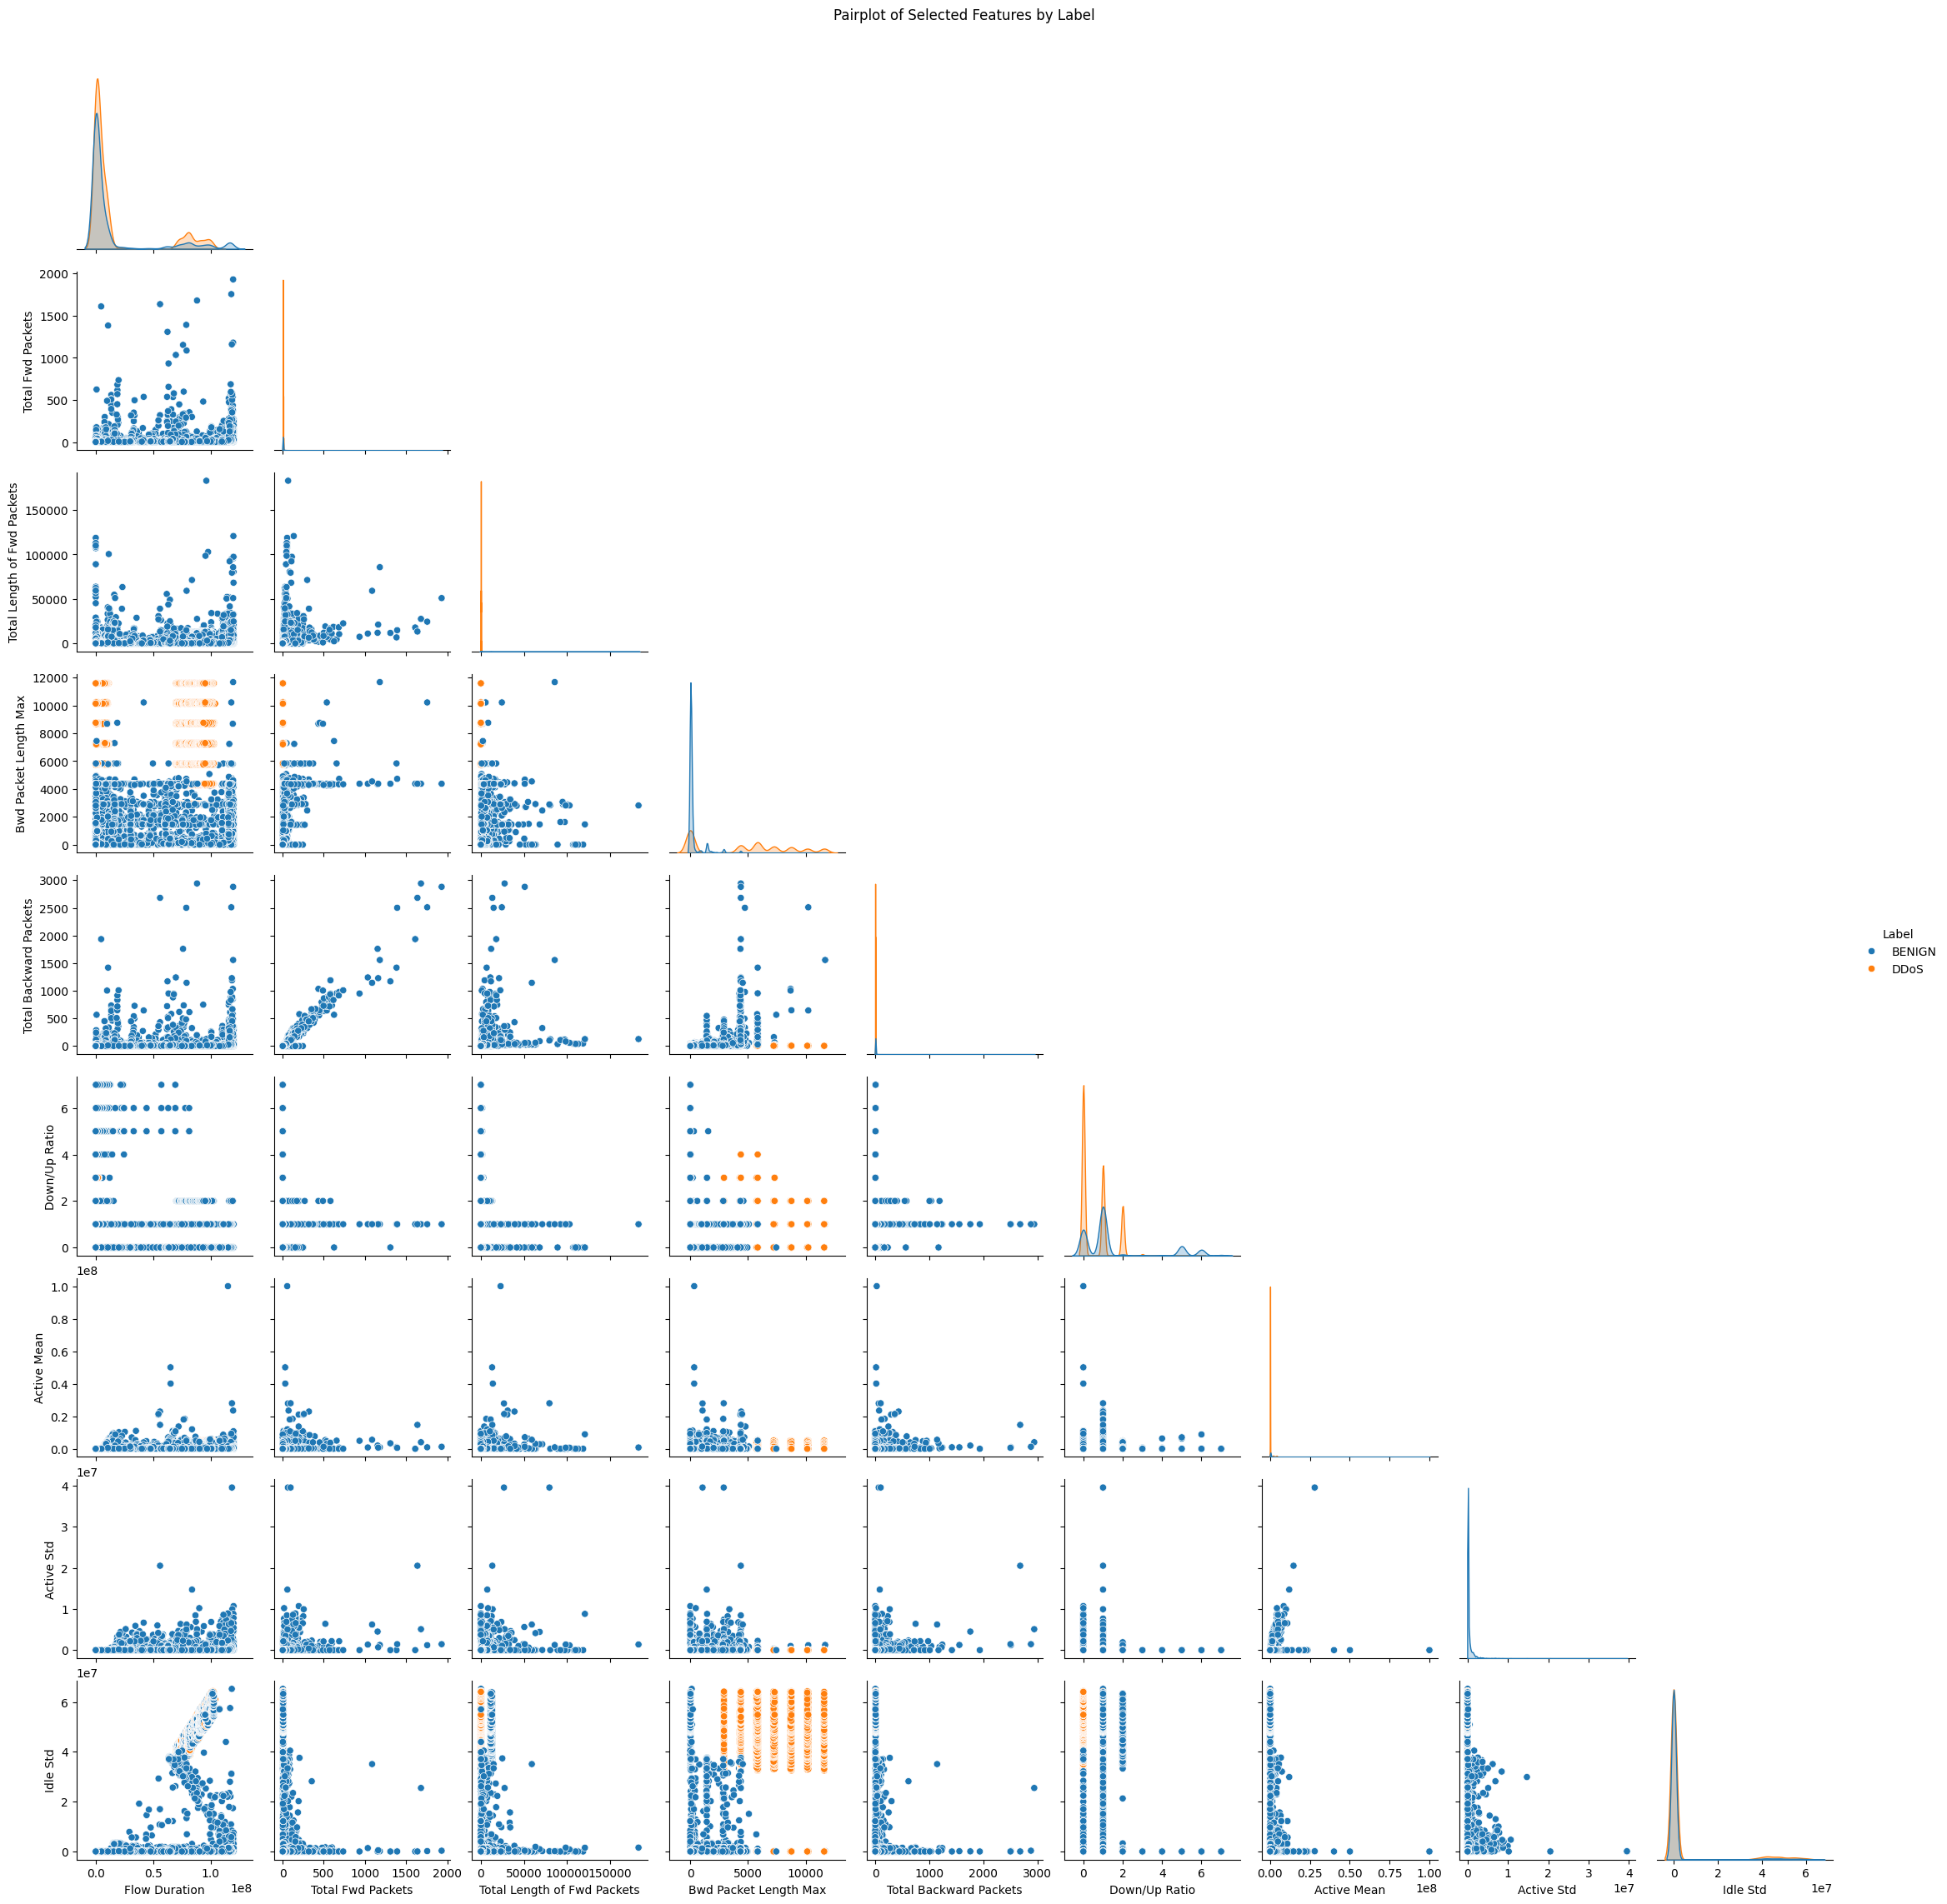

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Scatter Plot of Flow Duration vs Total Fwd Packets
plt.figure(figsize=(4, 4))
sns.scatterplot(data=data, x='Flow Duration', y='Total Fwd Packets', hue='Label', alpha=0.7)
plt.title("Scatter Plot: Flow Duration vs Total Fwd Packets")
plt.xlabel("Flow Duration")
plt.ylabel("Total Fwd Packets")
plt.show()

# Pair Plot - Using a subset of important numerical features
subset_columns = [
    'Flow Duration', 'Total Fwd Packets', 'Total Length of Fwd Packets', 'Bwd Packet Length Max',
    'Total Backward Packets', 'Down/Up Ratio', 'Active Mean', 'Active Std', 'Idle Std', 'Label'
]
available_cols = [col for col in subset_columns if col in data.columns]
print("Columns used for pairplot:", available_cols)

# Creating the pairplot
g = sns.pairplot(data[available_cols], hue='Label', diag_kind='kde', corner=True)
g.fig.suptitle("Pairplot of Selected Features by Label", y=1.02)
plt.show()

We can observe some clusters and separation in certain feature pairs, indicating that these features may be helpful in distinguishing between DDoS and benign traffic. However, there is also overlap, suggesting that multiple features and more complex methods will likely be needed for robust classification.


In [183]:
 #3. Group Analysis: Compare feature means by Label
numeric_cols = data.select_dtypes(include=[np.number]).columns
group_stats = data.groupby('Label')[numeric_cols].mean()
print("Grouped Mean Statistics by Label:\n", group_stats)


Grouped Mean Statistics by Label:
          Source Port  Destination Port  Protocol  Flow Duration  \
Label                                                             
BENIGN  27998.473608      20406.991516  9.696934   1.530626e+07   
DDoS    46087.934069         81.227382  6.000000   1.695559e+07   

        Total Fwd Packets  Total Backward Packets  \
Label                                               
BENIGN           5.402229                6.298205   
DDoS             4.472439                3.255821   

        Total Length of Fwd Packets  Total Length of Bwd Packets  \
Label                                                              
BENIGN                  2128.512567                  4109.003612   
DDoS                      31.908597                  7373.634999   

        Fwd Packet Length Max  Fwd Packet Length Min  ...  \
Label                                                 ...   
BENIGN            1224.589533              61.549848  ...   
DDoS                14.8976


This table shows the average (mean) of each numeric feature for BENIGN and DDoS classes. Several features (e.g., **Source Port**, **Bwd Packet Length Max**) differ substantially between BENIGN and DDoS, suggesting these may be useful for distinguishing attacks from normal traffic.

Also,some features (like **Flow Bytes/s**) appear as infinity, indicating potential outliers that may require additional handling in data cleaning or feature engineering.


In [184]:
def normalize_timestamp(data):
    data['Timestamp'] = pd.to_datetime(data['Timestamp'])
    data.sort_values(by='Timestamp', inplace=True)

normalize_timestamp(data)


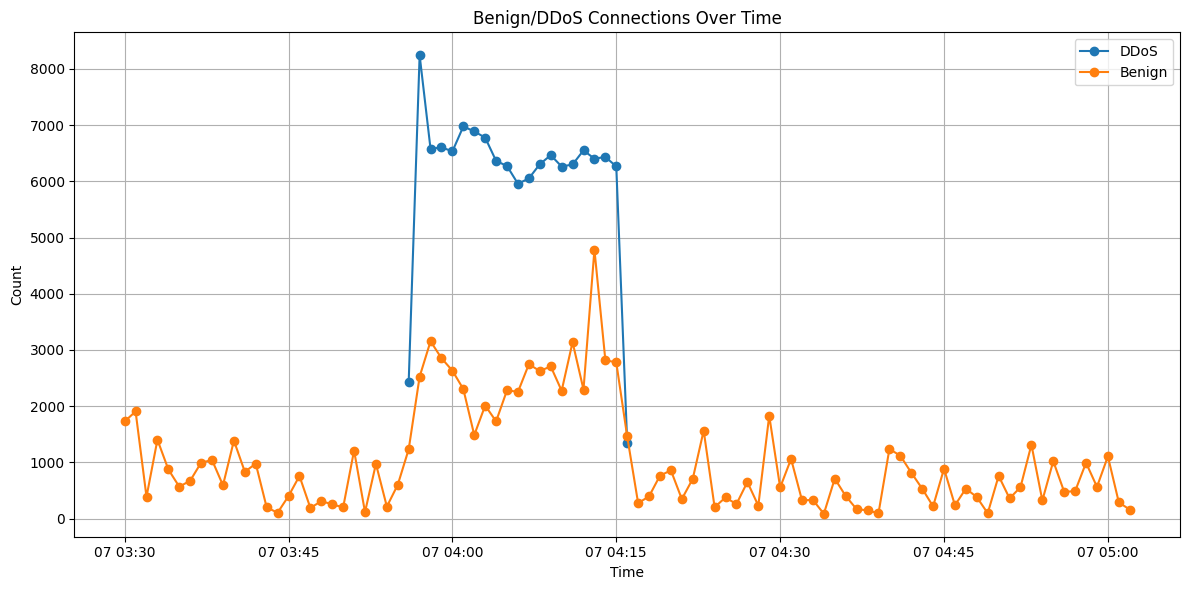

In [185]:
connection_by_time_b=data[data['Label']=='BENIGN'].groupby('Timestamp').size()
connection_by_time_nb=data[data['Label']!='BENIGN'].groupby('Timestamp').size()
plt.figure(figsize=(12, 6))
plt.plot(connection_by_time_nb.index, connection_by_time_nb.values, marker='o', linestyle='-',label='DDoS')
plt.plot(connection_by_time_b.index, connection_by_time_b.values, marker='o', linestyle='-', label='Benign')
plt.title('Benign/DDoS Connections Over Time')
plt.xlabel('Time')
plt.ylabel('Count')
#plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

Although this dataset contains more connections associated with DDoS attacks, the connections labeled as benign are more evenly distributed over time. Conversely, connections labeled as DDoS attacks are concentrated within a short time interval, with a high number of requests. Additionally, within this time interval, the number of connections labeled as benign is also relatively high.

This tell us we can also consider it as a Time Series Model and we can use "TimeStamp" as an index.

## **Data Preprocessing and Feature Engineering**

In [186]:
data.drop(['Label_numeric'],axis=1,inplace=True)

In [187]:
data[[ 'Flow ID','Destination IP','Source IP', 'Destination Port','Source Port','Protocol']]

,Flow ID,Destination IP,Source IP,Destination Port,Source Port,Protocol
0,192.168.10.5-104.16.207.165-54865-443-6,192.168.10.5,104.16.207.165,54865,443,6
863,192.168.10.3-192.168.10.5-53-56938-17,192.168.10.3,192.168.10.5,53,56938,17
1,192.168.10.5-104.16.28.216-55054-80-6,192.168.10.5,104.16.28.216,55054,80,6
2,192.168.10.5-104.16.28.216-55055-80-6,192.168.10.5,104.16.28.216,55055,80,6
3,192.168.10.16-104.17.241.25-46236-443-6,192.168.10.16,104.17.241.25,46236,443,6
...,...,...,...,...,...,...
225742,192.168.10.15-72.21.91.29-61375-80-6,192.168.10.15,72.21.91.29,61375,80,6
225666,192.168.10.19-66.70.172.17-123-123-17,66.70.172.17,192.168.10.19,123,123,17
225735,192.168.10.15-52.84.145.216-61301-80-6,192.168.10.15,52.84.145.216,61301,80,6
225593,151.101.0.249-192.168.10.17-443-46641-6,192.168.10.17,151.101.0.249,46641,443,6


It seems like the 'Flow ID' column contains concatenated information about source IP, destination IP, destination port, and protocol. We can drop it since it won't add much value.

In [188]:
data.drop(['Flow ID'],axis=1,inplace=True)

### Data Preprocessing Pipeline Summary

- **Null & Duplicate Checks:**  
  - Remove null values per column and remove any duplicate rows.

- **Remove Single-Value Columns:**  
  - Drop columns that contain only one unique value.

- **Correlation Filtering:**  
  - Compute the correlation matrix for numeric features and remove columns with correlations above 0.85 to reduce multicollinearity.

- **Label Encoding:**  
  - Encode the target column ('Label') into numeric values.
  - Encode IP address columns ('Source IP' and 'Destination IP') into numeric labels.

- **Infinite Value Handling:**  
  - Identify and drop columns containing infinite values.

This pipeline cleans and transforms the data, making it ready for further analysis and model training.


In [191]:
def preprocess_data(df, correlation_threshold=0.85):

    """
    Preprocess the given DataFrame by:
      1. Checking for null values and duplicates.
      2. Dropping columns with only one unique value.
      3. Removing highly correlated columns above 'correlation_threshold'.
      4. Label-encoding the 'Label' column.
      5. Label-encoding the 'Source IP' and 'Destination IP' columns.
      6. Identifying and removing columns with infinite values.

    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame to preprocess.
    correlation_threshold : float, optional
        The correlation threshold above which columns will be dropped.
        Default is 0.85.

    Returns:
    --------
    pd.DataFrame
        The preprocessed DataFrame.
    """

    from sklearn.preprocessing import LabelEncoder

    data = df.copy()

    #1. Check for null values and duplicates
    #print("Null values in each column:")
    #print(data.isnull().sum())

    duplicates_count = data.duplicated().sum()
    print("\nNumber of duplicate rows:", duplicates_count)
    if duplicates_count > 0:
        data.drop_duplicates(inplace=True)

    #2. Drop columns with only one unique value
    unique_value_cols = [col for col in data.columns if data[col].nunique() == 1]
    print("\nColumns with a single unique value:", unique_value_cols)
    if unique_value_cols:
        data.drop(unique_value_cols, axis=1, inplace=True)

    #3. Remove highly correlated columns
    numeric_data = data.select_dtypes(include=[np.number])
    corr_matrix = numeric_data.corr().abs()

    # Upper triangle of the correlation matrix
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    #Columns with correlation above the threshold
    high_corr_columns = [
        column for column in upper_triangle.columns
        if any(upper_triangle[column] > correlation_threshold)
    ]
    print("\nHighly correlated columns to drop:", high_corr_columns)
    if high_corr_columns:
        data.drop(high_corr_columns, axis=1, inplace=True)

    #4. Label-encode the target column 'Label'

    if 'Label' in data.columns:
        le_label = LabelEncoder()
        data['Label'] = le_label.fit_transform(data['Label'])
        label_map = {idx: cl for idx, cl in enumerate(le_label.classes_)}
        print("\nLabel encoding for 'Label':", label_map)
    else:
        print("\n'Label' column not found; skipping label encoding.")

    # 5. Label-encode IP addresses (Source IP, Destination IP)
    if 'Source IP' in data.columns and 'Destination IP' in data.columns:
        le_ip = LabelEncoder()
        full_ip_address = pd.concat([data['Source IP'], data['Destination IP']])
        le_ip.fit(full_ip_address)

        ip_mapping = {ip: idx for idx, ip in enumerate(le_ip.classes_)}
        print("\nMapping from IP addresses to numeric labels (sample):",
              dict(list(ip_mapping.items())[:5]), "...")

        data['Source IP'] = le_ip.transform(data['Source IP'])
        data['Destination IP'] = le_ip.transform(data['Destination IP'])
    else:
        print("\n'IP' columns not found; skipping IP address encoding.")

    #6. Identify and remove columns with infinite values
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    data_numeric = data[numeric_cols]

    is_infinite = np.any(np.isinf(data_numeric), axis=0)
    infinite_columns = data_numeric.loc[:, is_infinite].columns
    if len(infinite_columns) > 0:
        print("\nColumns containing infinite values:", list(infinite_columns))
        data.drop(columns=infinite_columns, inplace=True)
    else:
        print("\nNo columns with infinite values found.")

    return data


In [192]:
cleaned_data = preprocess_data(data, correlation_threshold=0.85)
print("\nShape of cleaned data:", cleaned_data.shape)
cleaned_data.head()



Number of duplicate rows: 2

Columns with a single unique value: ['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'CWE Flag Count', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']

Highly correlated columns to drop: ['Total Backward Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'SYN Flag Count', 'ECE Flag Count', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Fwd Header Length.1', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Byte

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Min,...,ACK Flag Count,URG Flag Count,Down/Up Ratio,Init_Win_bytes_forward,Init_Win_bytes_backward,min_seg_size_forward,Active Mean,Active Std,Idle Std,Label
0,24,443,871,54865,6,2017-07-07 03:30:00,3,2,12,6,...,1,0,0,33,-1,20,0.0,0.0,0.0,0
863,871,56938,870,53,17,2017-07-07 03:30:00,23380,2,70,35,...,0,0,1,-1,-1,32,0.0,0.0,0.0,0
1,39,80,871,55054,6,2017-07-07 03:30:00,109,1,6,6,...,1,1,1,29,256,20,0.0,0.0,0.0,0
2,39,80,871,55055,6,2017-07-07 03:30:00,52,1,6,6,...,1,1,1,29,256,20,0.0,0.0,0.0,0
3,47,443,865,46236,6,2017-07-07 03:30:00,34,1,6,6,...,1,1,1,31,329,20,0.0,0.0,0.0,0


### EDA Summary and Key Insights

- **Data Quality:**  
  - Checked for null values and duplicates; removed duplicate rows and dropped columns with only one unique value.
  
- **Correlation Analysis:**  
  - Identified and removed features with correlations above 0.85 to reduce redundancy and multicollinearity.
  
- **Distribution & Outlier Analysis:**  
  - Histograms and boxplots (e.g., for Flow Duration) revealed skewed distributions and more extreme outliers in DDoS traffic compared to benign traffic.
  
- **Grouped Analysis:**  
  - Grouping statistics by attack label highlighted key differences (such as in packet lengths and flow durations) that help distinguish DDoS from benign traffic.
  
- **Feature Engineering Impact:**  
  - The EDA informed the selection of features with strong relationships to the target, streamlined the feature set by removing highly correlated ones, and identified areas for potential feature transformation.


**Feature Scaling and Splitting Data for Model Training**

In [194]:
scaler=StandardScaler()
def scale_num_features(data):

  numeric_cols = data.select_dtypes(include=[np.number]).columns
  #data_numeric = data[numeric_cols]
  data[numeric_cols]=scaler.fit_transform(data[numeric_cols])

In [195]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


#Label is the target variable so dropping that
X = cleaned_data.drop('Label', axis=1)
y = cleaned_data['Label']

scale_num_features(X)

# First split: 70% training, 30% temporary (for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, stratify=y, random_state=42)

# Second split: split the temporary set equally into validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (135445, 32)
Validation set shape: (45149, 32)
Test set shape: (45149, 32)


In [196]:
if 'Timestamp' in X_train.columns:
    X_train = X_train.drop('Timestamp', axis=1)
if 'Timestamp' in X_test.columns:
    X_test = X_test.drop('Timestamp', axis=1)
if 'Timestamp' in X_val.columns:
    X_val = X_val.drop('Timestamp', axis=1)

## Model Training

### Method for Detecting DDoS Attacks

For this project, I chose a machine learning-based classification approach to distinguish between DDoS attacks and benign traffic.I here use an ensemble of classifiers (e.g., Random Forest, XGBoost) because of their robustness, scalability, and ability to capture complex patterns in high-dimensional data.

**Reasoning:**
- **Robustness:** Ensemble methods effectively handle noisy and diverse network data.
- **Interpretability:** They provide feature importance insights, helping us understand which traffic characteristics differentiate DDoS from benign labels.
- **Scalability:** These models can efficiently process large datasets like our traffic analysis dataset.

**Advantages:**
- Captures non-linear relationships and complex interactions between features.
- Offers insights into key features for **DDoS** detection process.

**Potential Limitations:**
- Requires careful hyperparameter tuning to avoid overfitting.
- May need regular updates to capture new or evolving attack patterns.
- Computationally intensive when scaling to extremely large datasets.

This strategy offers a balanced approach to detecting DDoS attacks, providing both performance and interpretability while being mindful of potential limitations.


In [197]:
# Function to train models on the training set
def train_models(X_train, y_train):
    """
    Train several classifiers on the training data.

    Returns:
        dict: A dictionary of trained models.
    """
    from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.neural_network import MLPClassifier
    from xgboost import XGBClassifier

    classifiers = {
        "Random Forest": RandomForestClassifier(random_state=42),
        "KNN": KNeighborsClassifier(n_neighbors=10),
        "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    }

    trained_models = {}
    for name, model in classifiers.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        trained_models[name] = model
    return trained_models

# Train the models on the training set
trained_models = train_models(X_train, y_train)

Training Random Forest...
Training KNN...
Training Extra Trees...
Training MLP Classifier...
Training XGBoost...


Evaluating Random Forest on validation set...
Evaluating KNN on validation set...
Evaluating Extra Trees on validation set...
Evaluating MLP Classifier on validation set...
Evaluating XGBoost on validation set...


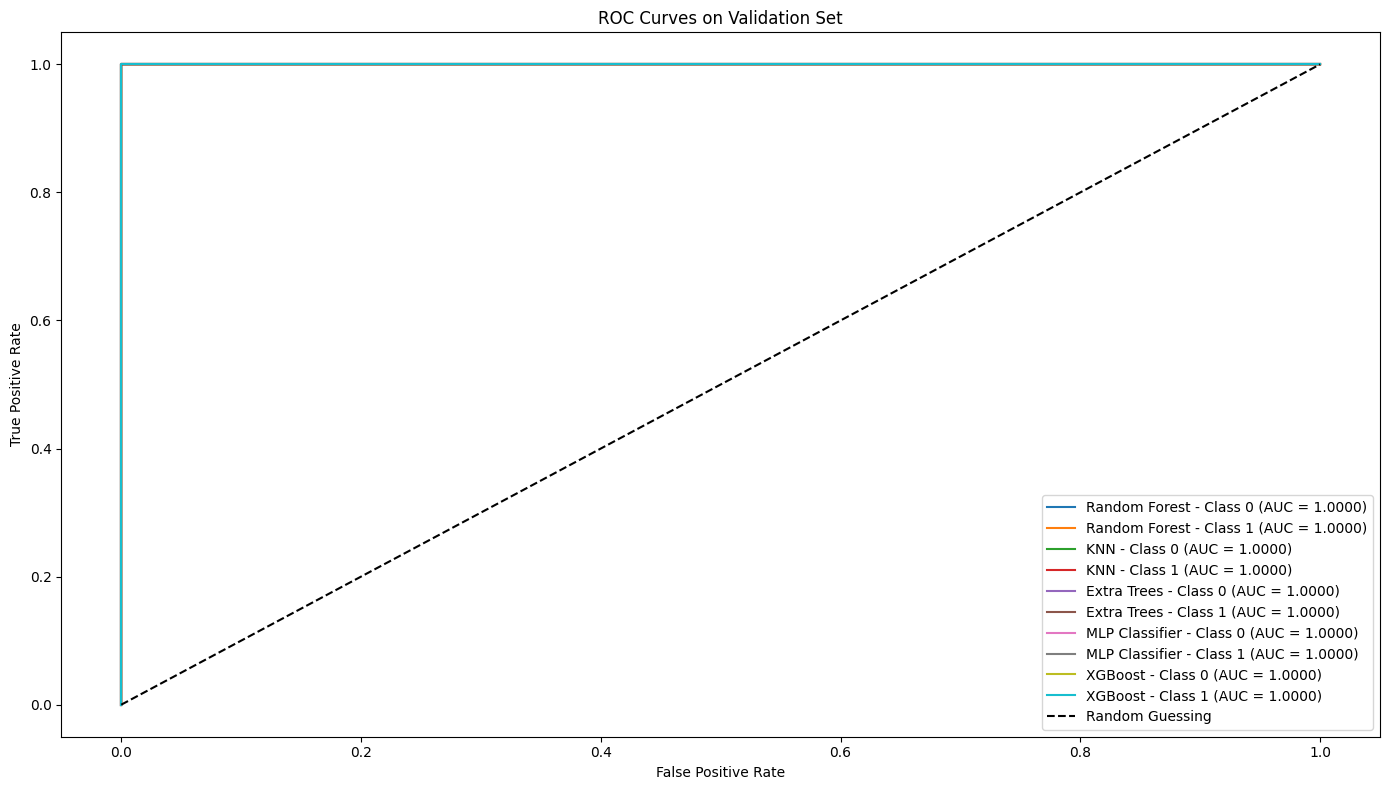

Validation Scores:
            Model  Accuracy  Precision    Recall  F1 Score  ROC AUC
0   Random Forest  1.000000   1.000000  1.000000  1.000000  1.00000
1             KNN  0.999934   0.999934  0.999934  0.999934  0.99998
2     Extra Trees  1.000000   1.000000  1.000000  1.000000  1.00000
3  MLP Classifier  0.999978   0.999978  0.999978  0.999978  1.00000
4         XGBoost  1.000000   1.000000  1.000000  1.000000  1.00000


In [199]:
#Model Evaluation on the Validation Set

def evaluate_models(trained_models, X_val, y_val):
    """
    Evaluate trained models on the validation set.

    Returns:
        pd.DataFrame: A DataFrame containing evaluation metrics for each model.
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    scores_list = []
    plt.figure(figsize=(14,8))

    for name, model in trained_models.items():
        print(f"Evaluating {name} on validation set...")
        y_pred = model.predict(X_val)

        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)

        #To compute ROC AUC
        roc_auc = None
        try:
            y_proba = model.predict_proba(X_val)
            n_classes = len(np.unique(y_val))
            if n_classes > 2:
                roc_auc = roc_auc_score(y_val, y_proba, multi_class="ovr")
            else:
                roc_auc = roc_auc_score(y_val, y_proba[:, 1])

            # Plotting ROC curves for each class
            for i in range(n_classes):
                fpr, tpr, _ = roc_curve(y_val, y_proba[:, i], pos_label=i)
                plt.plot(fpr, tpr, label=f'{name} - Class {i} (AUC = {roc_auc:.4f})')
        except Exception as e:
            print(f"{name} does not support predict_proba. Skipping ROC curve. Error: {e}")

        scores_list.append({
            "Model": name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "ROC AUC": roc_auc
        })

    plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves on Validation Set")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    scores_df = pd.DataFrame(scores_list)
    return scores_df

# Evaluate the trained models on the validation set
val_scores = evaluate_models(trained_models, X_val, y_val)
print("Validation Scores:")
print(val_scores)


**Display the Accuracy Score Plot**


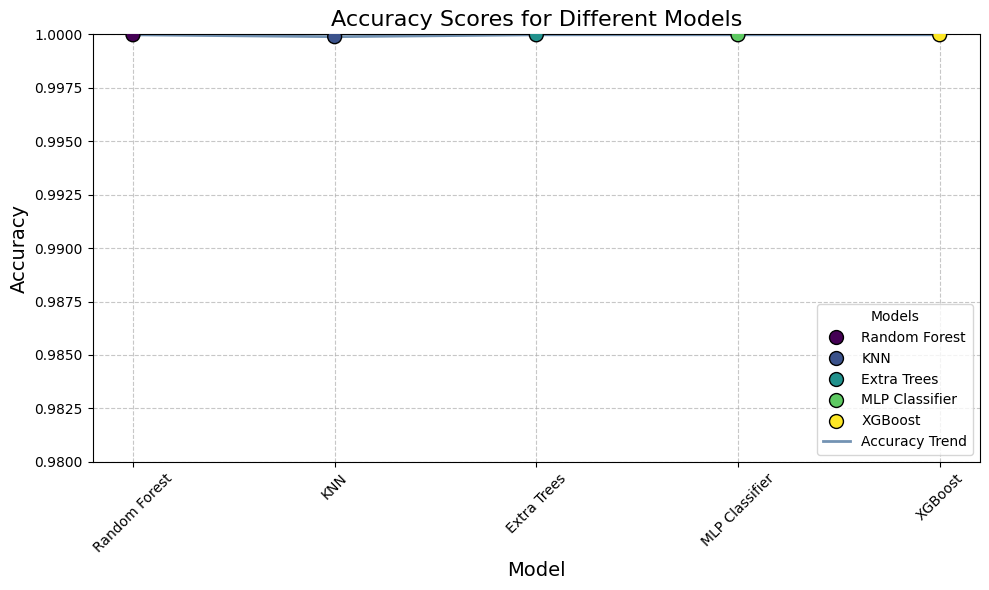

In [200]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.lines import Line2D


models = scores['Model'].tolist()
accuracy = scores['Accuracy'].tolist()


num_models = len(models)
colors = cm.viridis(np.linspace(0, 1, num_models))

plt.figure(figsize=(10, 6))

# Plotting accuracy points using scatter
plt.scatter(models, accuracy, s=100, c=colors, edgecolor='k', zorder=3)


plt.plot(models, accuracy, linestyle='-', color='#7393B3', linewidth=2, zorder=2)

# Customizing the plot
plt.title("Accuracy Scores for Different Models", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.ylim(0.98, 1)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)


custom_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i],
                           markersize=10, markeredgecolor='k') for i in range(num_models)]

custom_handles.append(Line2D([0], [0], color='#7393B3', lw=2))
legend_labels = models + ["Accuracy Trend"]

plt.legend(custom_handles, legend_labels, loc="lower right", title="Models")

plt.tight_layout()
plt.show()


In [201]:
#the best model based on Accuracy metric
best_model_name = val_scores.sort_values(by="Accuracy", ascending=False).iloc[0]["Model"]
print("Best model based on validation accuracy is:", best_model_name)
best_model = trained_models[best_model_name]


Best model based on validation accuracy is: Random Forest


**Final Evaluation on the Test Set**

Classification Report on Test Set for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19544
           1       1.00      1.00      1.00     25605

    accuracy                           1.00     45149
   macro avg       1.00      1.00      1.00     45149
weighted avg       1.00      1.00      1.00     45149



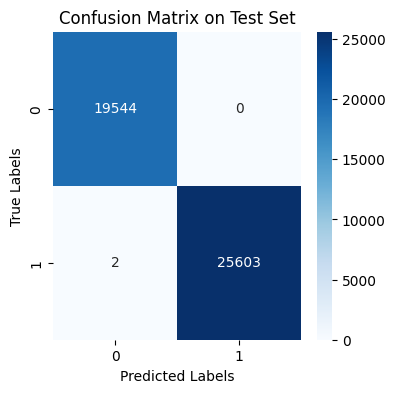

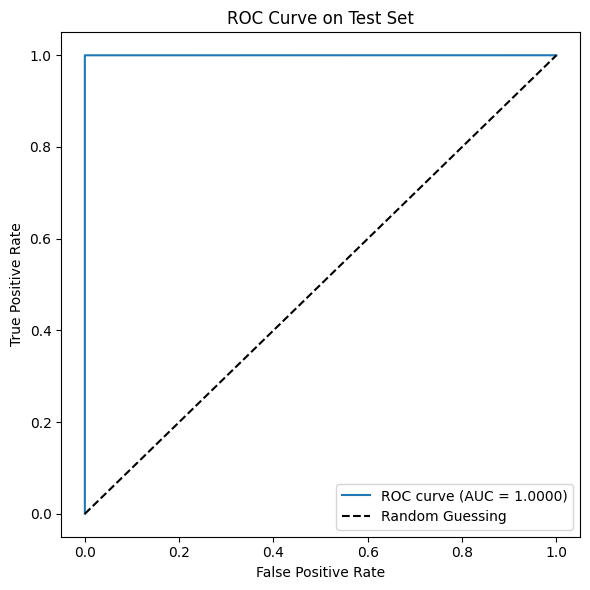

In [202]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict on the test set using the best model
y_test_pred = best_model.predict(X_test)

# Print classification report
print(f"Classification Report on Test Set for {best_model_name}:")
print(classification_report(y_test, y_test_pred))

# Compute and display the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix on Test Set")
plt.show()

# Compute and plot ROC curve for the test dataset
try:
    y_test_proba = best_model.predict_proba(X_test)
except AttributeError:
    print(f"{best_model_name} does not support predict_proba, ROC curve cannot be computed.")
else:
    n_classes = len(np.unique(y_test))
    plt.figure(figsize=(6, 6))

    # For binary classification
    if n_classes == 2:
        auc = roc_auc_score(y_test, y_test_proba[:, 1])
        fpr, tpr, _ = roc_curve(y_test, y_test_proba[:, 1])
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')

    # For multiclass classification
    else:
        auc = roc_auc_score(y_test, y_test_proba, multi_class="ovr")
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test, y_test_proba[:, i], pos_label=i)
            plt.plot(fpr, tpr, label=f'Class {i} ROC (AUC = {auc:.4f})')

    # Add diagonal line for random guessing
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve on Test Set")
    plt.legend(loc="lower right")
    plt.tight_layout()




### Evaluation Summary

The Random Forest model achieved a perfect classification on the test set, with **100% accuracy**, **precision**, **recall**, and **F1-score** for both classes. The confusion matrix shows zero misclassifications (all BENIGN flows are correctly labeled as 0, and all DDoS flows as 1).

The **ROC curve** also indicates an **AUC of 1.0**, confirming no false positives or false negatives.

While these results are perfect, it’s important next step to validate the model on additional data or any real-world scenarios to ensure it generalizes beyond this dataset and is not overfitting.


In [203]:
import pickle

# Assume 'best_model' is your trained model
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)


In [204]:
!ls -lh best_model.pkl

-rw-r--r-- 1 root root 378K Mar  7 08:00 best_model.pkl


In [206]:
from google.colab import files
files.download('best_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Model Serving:**  
   - I implemented a Flask API (in `app.py`) to serve the best model.  
   - The API includes a root route (`/`) for a welcome message and a `/predict` endpoint that accepts JSON input and returns predictions.
   - Detailed instructions for running the Flask app are provided in the README.md
